In [1]:
%matplotlib ipympl

import numpy as np
import torch
from pytorch3d.transforms import axis_angle_to_matrix, matrix_to_axis_angle
from pytorch3d.loss import chamfer_distance
from smplx import SMPLXLayer

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.animation as animation

from torch.optim import Adam
from torch.optim.lr_scheduler import CyclicLR

from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
BASE_LR = 1e-5
MAX_LR = 5e-3
INITIAL_LR = MAX_LR

N_ITERS = 10_000
STEP_SIZE = 10 # number of iterations between each frame in the animation
N_FRAMES = N_ITERS // STEP_SIZE

FPS = 60

## Target Point Cloud
Utilizes SMPL-X to generate a point cloud for alignment. No correspondence information is assumed for this example.

In [ ]:
npz_data = np.load("amass/custom/bzo/Aydin-2.iso07.0_stageii.npz", allow_pickle=True)

poses = npz_data["poses"]

rng = np.random.default_rng()

target = rng.choice(poses, axis=0)
target = torch.tensor(target).to(device)

target_orient = target[0]
target_orient = axis_angle_to_matrix(target_orient).float()

while target_orient.dim() < 4:
    target_orient = target_orient.unsqueeze(0)

target_body_pose = target[1:]
target_body_pose = axis_angle_to_matrix(target_body_pose).float()

while target_body_pose.dim() < 4:
    target_body_pose = target_body_pose.unsqueeze(0)

model = SMPLXLayer(
    model_path = "models/smplx",
    gender="neutral",
    ext="npz"
).to(device)

target_vertices = model(
    orient=target_orient,
    body_pose=target_body_pose,
).vertices


## Initial Pose

Let's initialize the source pose with the default pose of the SMPLX model.
The initial pose parameters (axis-angles) are then made differentiable for optimization.
We're operating on axis-angles, not rotation matrices, for the fact that rotation matrices need to be orthogonal and thus have a determinant of 1. This is a hard constraint to satisfy while doing optimization.

In [4]:
source_output = model()

source_orient = source_output.global_orient
source_orient = matrix_to_axis_angle(source_orient).float()
source_orient.requires_grad = True

source_body_pose = source_output.body_pose
source_body_pose = matrix_to_axis_angle(source_body_pose).float()
source_body_pose.requires_grad = True


## Distance

We use the `Chamfer Distance` as our loss function to measure the difference between the source model and target point cloud. Two-way Chamfer Distance is used here because it provides a more robust measure of distance between two point clouds.

## Optimization
We're giving `axis-angles` to the optimizer, not the model.
We will convert them back to rotation matrices before giving them to the model, thus ensure orthogonality of the rotation matrices.

## Learning Rate Schedule

We're using a learning rate schedule to help the ICP process converge faster and achieve better results. Initially, when the pose is far from the target, we use a relatively higher learning rate to make large adjustments. As the pose gets closer to the target, we reduce the learning rate to avoid overshooting and fine-tune the alignment.

*   **Initial High Learning Rate:**  The initial learning rate (`INITIAL_LR`) is relatively high to allow for significant changes to the pose in the early iterations.

*   **Learning Rate Decay:** The learning rate is reduced over time to refine the alignment and avoid oscillations. This allows for more precise adjustments when the pose is close to the target.

*   **Final Learning Rate Increase:**  In the final 10% of iterations, we briefly increase the learning rate again. This is a heuristic to help the ICP process escape from local minima and achieve even better alignment.  The idea is that after many iterations, the algorithm may be stuck in a suboptimal solution, and a brief increase in learning rate can help it jump out of that local minimum.

In [5]:
loss = chamfer_distance
optimizer = Adam([source_orient, source_body_pose], lr=5e-3)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=5e-3, step_size_down=int(N_ITERS * 0.9), step_size_up=int(N_ITERS * 0.1))

In [6]:
def plot_smpl(ax, orient, body_pose, face_color=(0.07, 0.07, 0.1), edge_color=(0.54, 0.71, 0.98)):

    if orient.dim() == 3:
        orient = axis_angle_to_matrix(orient)
    
    if body_pose.dim() == 3:
        body_pose = axis_angle_to_matrix(body_pose)

    output = model(
        orient=orient,
        body_pose=body_pose,
    )

    vertices = output.vertices.detach().cpu().numpy().squeeze()
    joints = output.joints.detach().cpu().numpy().squeeze()

    mesh = Poly3DCollection(vertices[model.faces], alpha=0.8)

    mesh.set_facecolor(face_color)
    mesh.set_edgecolor(edge_color)

    ax.add_collection3d(mesh)
    ax.scatter(joints[:, 0], joints[:, 1], joints[:, 2], alpha=0.1)

The entire training process is integrated into a Matplotlib animation pipeline. While this approach provides a visually compelling and detailed representation of the alignment process, it comes with a significant performance trade-off. However, this performance cost is justified by the benefits of visualization.

Aligning & Plotting: 100%|██████████| 10000/10000 [13:40<00:00, 12.55it/s]

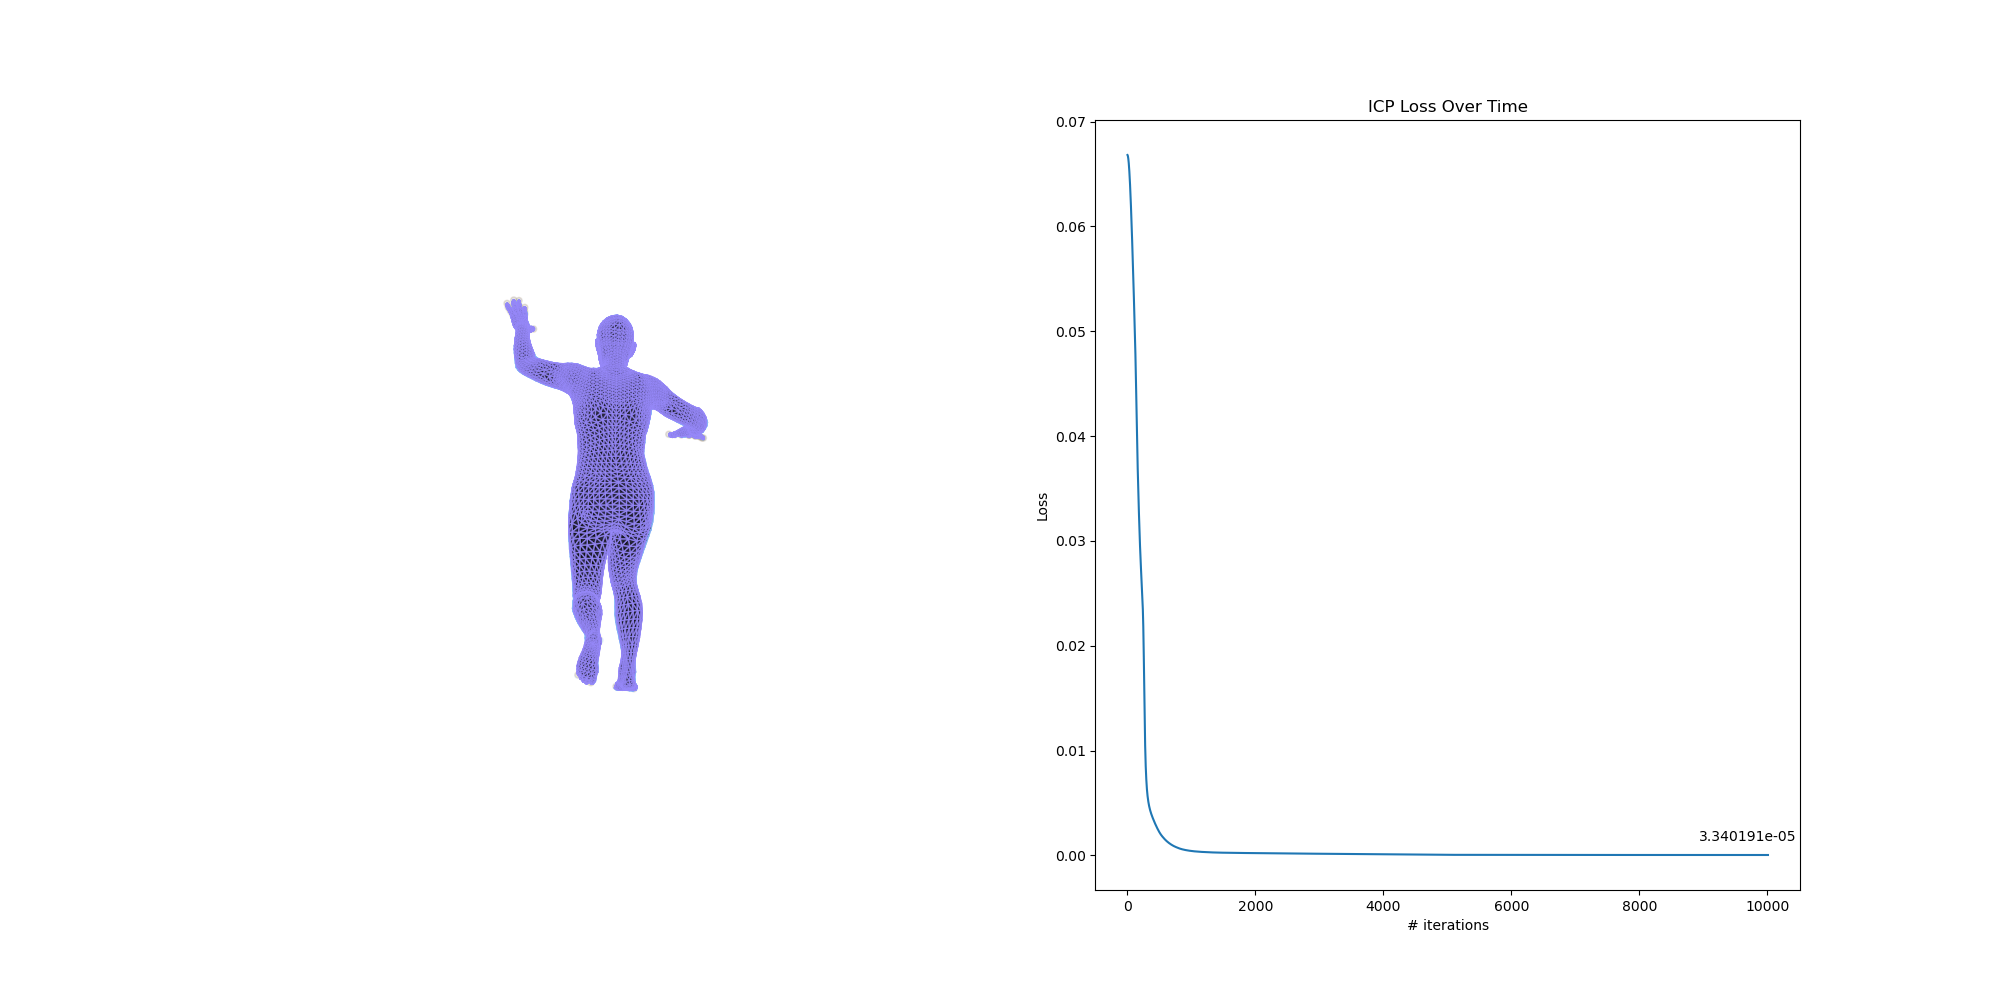

In [7]:
losses = []

fig = plt.figure(figsize=(20, 10))
smpl_ax = fig.add_subplot(121, projection="3d")
loss_ax = fig.add_subplot(122)

smpl_ax.view_init(elev=91, azim=0, roll=90)

smpl_ax.set_xlim(-1, 1)
smpl_ax.set_zlim(-1, 1)

plt.axis('off')

def train_step(frame):

    for i in range(STEP_SIZE):
        optimizer.zero_grad()
        source_vertices = model(
            orient=axis_angle_to_matrix(source_orient),
            body_pose=axis_angle_to_matrix(source_body_pose),
        ).vertices
        loss_value, _ = chamfer_distance(source_vertices, target_vertices)
        loss_value.backward()
        optimizer.step()
        scheduler.step()
        losses.append(loss_value.item())

    smpl_ax.clear()
    smpl_ax.axis('off')
    smpl_ax.set_xlim(-1, 1)
    smpl_ax.set_zlim(-1, 1)


    plot_smpl(smpl_ax, source_orient, source_body_pose, edge_color=(0.592, 0.537, 0.98))
    plot_smpl(smpl_ax, target_orient, target_body_pose)
    
    smpl_ax.view_init(elev=91 + (2 * frame), azim=0, roll=90)

    loss_ax.clear()
    loss_ax.plot(range(len(losses)), losses)
    loss_ax.set_xlabel("# iterations")
    loss_ax.set_ylabel("Loss")
    loss_ax.set_title("ICP Loss Over Time")
    loss_ax.annotate(f"{losses[-1]:e}", xy=(len(losses)-1, losses[-1]), xycoords='data', xytext=(-50, 10), textcoords='offset points')


anim = animation.FuncAnimation(fig, train_step, frames=N_FRAMES, interval=1000/FPS, blit=True)
progress_bar = tqdm(total=N_ITERS, desc="Aligning & Plotting", position=0, leave=False)
update_func = lambda _i, _n: progress_bar.update(STEP_SIZE)
anim.save('icp-convergence.gif', writer='pillow', fps=FPS, progress_callback=update_func)
anim.pause()